In [20]:
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

# Resize images

In [2]:
IMG_PATH = Path('../VOCdevkit/VOC2007/JPEGImages')
NEW_PATH = Path('../VOCdevkit/VOC2007/JPEGImages_300_300')

In [3]:
str(list(IMG_PATH.iterdir())[0]).split('/')[-1]

'007622.jpg'

In [4]:
def resize_img_and_write():
    for path in tqdm(list(IMG_PATH.iterdir())):
        img = cv2.imread(str(path))
        x_resized = cv2.resize(img, (300, 300))
        fname = str(path).split('/')[-1]
        cv2.imwrite(str(NEW_PATH/fname), x_resized)

In [ ]:
resize_img_and_write()

# Resize bboxes

In [5]:
def make_bb_px(y, x_shape):
    """Makes an image of size x retangular bounding box"""
    Y = np.zeros(x_shape)
#     print(y)
    y = hw_bb(y).astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y


def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def hw_bb(bb): 
    """Transform from width-height format to bounding box format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])


def bb_hw(bb): 
    """Transform from bounding box format to width-height format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

In [21]:
PATH = Path('../VOCdevkit/VOC2007/')
train_bbox_df = pd.read_csv(PATH/'tmp/train_bbox_multi.csv')
val_bbox_df = pd.read_csv(PATH/'tmp/val_bbox_multi.csv')

In [7]:
# resize bounding boxes accordingly
def resize_bbox(orig_shape, bbox, target_shape=(300, 300)):
#     img = cv2.imread(str(IMG_PATH/path.split('/')[-1]))
#     r, c, _ = img.shape # original img size
    Y = make_bb_px(bbox, orig_shape)
    y_resize = cv2.resize(Y, target_shape)
    y = bb_hw(to_bb(y_resize))
    return ' '.join([str(int(n)) for n in y])

In [8]:
def resize_annotation_bbox(annotation):
    y_300 = []
    for i, bbox in enumerate(annotation['bbox']):
        path = annotation['fn'][i]
        img = cv2.imread(str(IMG_PATH/path.split('/')[-1]))
        r, c, _ = img.shape # original img size
        y = np.array([int(b) for b in bbox.split()])
        if len(y) == 4:
            y_300.append(resize_bbox((r, c), y))
        elif len(y) > 4:
            resized_bb = [resize_bbox((r, c), y[i*4:(i*4+4)]) for i in range(int(len(y)/4))]
            y_300.append(' '.join(resized_bb))
    
    annotation['bbox_300'] = y_300

In [ ]:
resize_annotation_bbox(train_bbox_df)

In [ ]:
resize_annotation_bbox(val_bbox_df)

In [9]:
train_bbox_df.head()

,fn,label,bbox,bbox_300
0,../../VOCdevkit/VOC2007/JPEGImages/000012.jpg,7,155 96 196 174,93 86 117 157
1,../../VOCdevkit/VOC2007/JPEGImages/000017.jpg,15 13,184 61 95 138 89 77 314 259,115 50 59 114 55 63 197 214
2,../../VOCdevkit/VOC2007/JPEGImages/000023.jpg,2 2 15 15 15,8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...,7 137 213 163 205 131 95 169 0 0 105 221 1 0 2...
3,../../VOCdevkit/VOC2007/JPEGImages/000026.jpg,7,89 124 248 88,53 111 149 80
4,../../VOCdevkit/VOC2007/JPEGImages/000032.jpg,1 1 15 15,103 77 272 106 132 87 65 36 194 179 19 50 25 1...,62 82 163 113 79 92 39 39 116 191 11 53 15 200...


In [10]:
val_bbox_df.head()

,fn,label,bbox,bbox_300
0,../../VOCdevkit/VOC2007/JPEGImages/000005.jpg,9 9 9,262 210 62 129 164 263 89 109 240 193 55 106,157 168 37 103 98 210 53 87 144 154 33 85
1,../../VOCdevkit/VOC2007/JPEGImages/000007.jpg,7,140 49 360 281,84 44 216 253
2,../../VOCdevkit/VOC2007/JPEGImages/000009.jpg,13 15 15 15,68 171 202 159 149 140 80 144 284 200 43 131 2...,41 136 121 128 89 112 48 115 170 160 26 104 15...
3,../../VOCdevkit/VOC2007/JPEGImages/000016.jpg,2,91 71 214 402,81 42 193 241
4,../../VOCdevkit/VOC2007/JPEGImages/000019.jpg,8 8,230 87 253 169 10 112 256 147,138 69 151 135 6 89 153 118


In [ ]:
train_bbox_df.to_csv(PATH/'tmp/train_bbox_multi.csv', index=False)
val_bbox_df.to_csv(PATH/'tmp/val_bbox_multi.csv', index=False)

In [11]:
def bounding_box(bb):
    """switch x/y coords to be consistent with numpy, convert height/width into top-left/bottom-right"""
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# open image
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

In [12]:
category = {1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

Bounding box:
Y: 70
X: 136
Height: 157
Width: 164
boat
Bounding box:
Y: 96
X: 9
Height: 130
Width: 168
boat


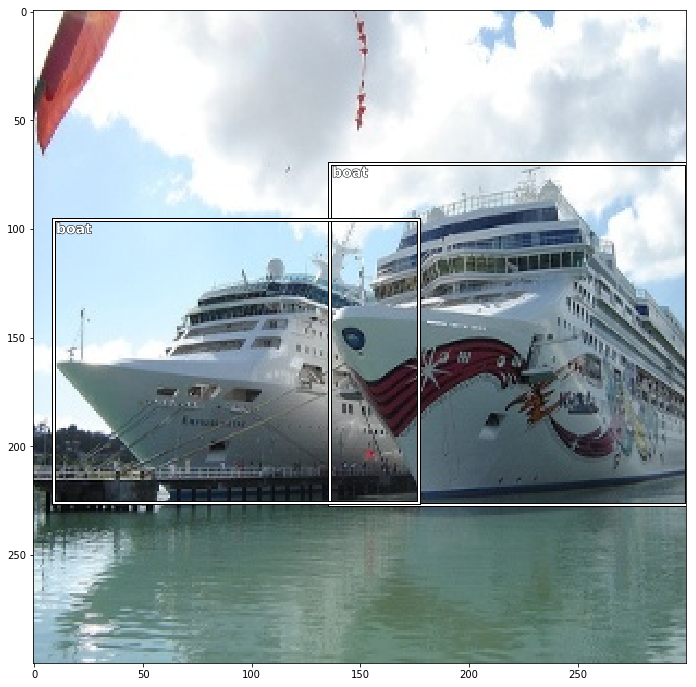

In [32]:
idx = np.random.randint(0, len(train_bbox_df), 1)
sample = train_bbox_df.iloc[idx, :]

img_path = '/'.join(sample['fn'].values[0].split('/')[1:])
boxes = [int(c) for c in sample['bbox_300'].values[0].split()]
img = load_image(img_path)
labels = [int(lab) for lab in sample['label'].values[0].split()]
ax = show_img(img, figsize=(12, 12))

for i in range(int(len(boxes)/4)):
    b = np.array(boxes[i*4:(i*4+4)])
    print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
    draw_rect(ax, b)
    text = category[labels[i]]
    print(text)
    draw_text(ax, b[:2]+1, text)